<a href="https://colab.research.google.com/github/Tecpandas/Pandas_Data-Analysis/blob/main/Another_copy_of_Detect_Behavavior_with_sensor_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
asthapal_sensor_data_path = kagglehub.dataset_download('asthapal/sensor-data')

print('Data source import complete.')
!pip install catboost



Data source import complete.


              row_id sequence_type sequence_id  sequence_counter      subject  \
0  SEQ_000007_000000        Target  SEQ_000007                 0  SUBJ_059520   
1  SEQ_000007_000001        Target  SEQ_000007                 1  SUBJ_059520   
2  SEQ_000007_000002        Target  SEQ_000007                 2  SUBJ_059520   
3  SEQ_000007_000003        Target  SEQ_000007                 3  SUBJ_059520   
4  SEQ_000007_000004        Target  SEQ_000007                 4  SUBJ_059520   

                       orientation                                   behavior  \
0  Seated Lean Non Dom - FACE DOWN  Relaxes and moves hand to target location   
1  Seated Lean Non Dom - FACE DOWN  Relaxes and moves hand to target location   
2  Seated Lean Non Dom - FACE DOWN  Relaxes and moves hand to target location   
3  Seated Lean Non Dom - FACE DOWN  Relaxes and moves hand to target location   
4  Seated Lean Non Dom - FACE DOWN  Relaxes and moves hand to target location   

        phase             

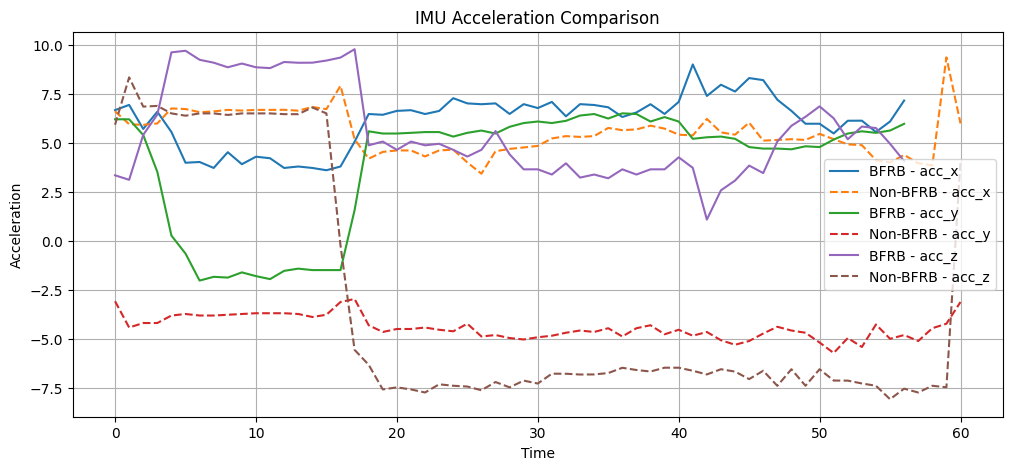

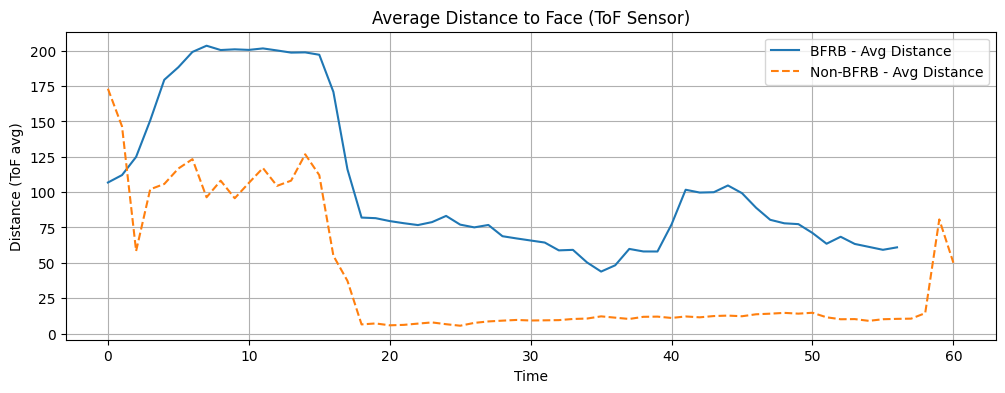

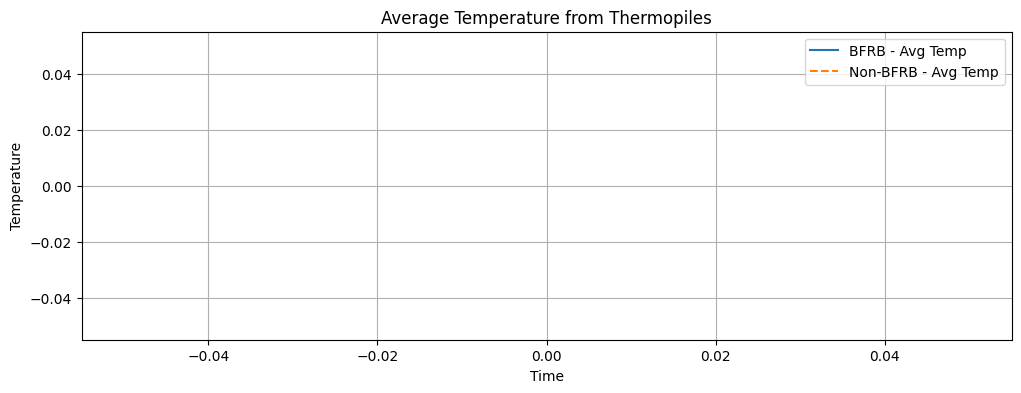

RandomForest Binary Classification CV Accuracy: 0.9212 ± 0.0056
Skipping multiclass gesture classification due to missing gesture labels.


In [9]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization (optional but useful)
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Feature extraction (time-series and signal processing)
from scipy.stats import skew, kurtosis
from scipy.fft import fft
from sklearn.decomposition import PCA

# Model training
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Deep learning (optional)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# LightGBM/XGBoost/CatBoost (for tabular data)
import lightgbm as lgb
import xgboost as xgb
import catboost

# Utility
import os
import warnings
warnings.filterwarnings("ignore")



df=pd.read_csv('/kaggle/input/sensor-data/train.csv')

print(df.head())
print(df.shape)
print(df.columns)
print(df.info())
df1=pd.read_csv('/kaggle/input/sensor-data/test.csv')

print(df1.head())
print(df1.shape)
print(df1.columns)
print(df1.info())
df2=pd.read_csv('/kaggle/input/sensor-data/train_demographics.csv')

print(df2.head())
print(df2.shape)
print(df2.columns)
print(df2.info())
df3=pd.read_csv('/kaggle/input/sensor-data/test_demographics.csv')

print(df3.head())
print(df3.shape)
print(df3.columns)
print(df3.info())


train_df = pd.read_csv('/kaggle/input/sensor-data/train.csv')
train_demo = pd.read_csv('/kaggle/input/sensor-data/train_demographics.csv')

imu_cols = [col for col in train_df.columns if col.startswith('acc_') or col.startswith('rot_')]
thermo_cols = [col for col in train_df.columns if col.startswith('thm_')]
tof_cols = [col for col in train_df.columns if col.startswith('tof_')]

print("IMU columns:", imu_cols[:5], "... total:", len(imu_cols))
print("Thermopile columns:", thermo_cols[:5], "... total:", len(thermo_cols))
print("ToF columns:", tof_cols[:5], "... total:", len(tof_cols))

print(train_df['sequence_type'].unique())
print(train_df['sequence_type'].value_counts())

print(train_df['sequence_id'].unique()[:5])

print(train_df.head())

# Fix: match capitalization
target_seq = train_df[train_df['sequence_type'] == 'Target']['sequence_id'].unique()[0]
non_target_seq = train_df[train_df['sequence_type'] == 'Non-Target']['sequence_id'].unique()[0]

target_sample = train_df[train_df['sequence_id'] == target_seq]
non_target_sample = train_df[train_df['sequence_id'] == non_target_seq]

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
for axis in ['acc_x', 'acc_y', 'acc_z']:
    plt.plot(target_sample['sequence_counter'], target_sample[axis], label=f'BFRB - {axis}')
    plt.plot(non_target_sample['sequence_counter'], non_target_sample[axis], '--', label=f'Non-BFRB - {axis}')
plt.title("IMU Acceleration Comparison")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Acceleration")
plt.grid(True)
plt.show()


tof_cols = [col for col in train_df.columns if col.startswith('tof_')]
target_sample['tof_avg'] = target_sample[tof_cols].replace(-1, np.nan).mean(axis=1)
non_target_sample['tof_avg'] = non_target_sample[tof_cols].replace(-1, np.nan).mean(axis=1)

plt.figure(figsize=(12, 4))
plt.plot(target_sample['sequence_counter'], target_sample['tof_avg'], label='BFRB - Avg Distance')
plt.plot(non_target_sample['sequence_counter'], non_target_sample['tof_avg'], '--', label='Non-BFRB - Avg Distance')
plt.title("Average Distance to Face (ToF Sensor)")
plt.xlabel("Time")
plt.ylabel("Distance (ToF avg)")
plt.legend()
plt.grid(True)
plt.show()

thermo_cols = [col for col in train_df.columns if 'thermopile' in col.lower()]
target_sample['temp_avg'] = target_sample[thermo_cols].replace(-1, np.nan).mean(axis=1)
non_target_sample['temp_avg'] = non_target_sample[thermo_cols].replace(-1, np.nan).mean(axis=1)

plt.figure(figsize=(12, 4))
plt.plot(target_sample['sequence_counter'], target_sample['temp_avg'], label='BFRB - Avg Temp')
plt.plot(non_target_sample['sequence_counter'], non_target_sample['temp_avg'], '--', label='Non-BFRB - Avg Temp')
plt.title("Average Temperature from Thermopiles")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.show()


import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Example function to extract features from one sequence group
def extract_features(group):
    features = {}

    # IMU sensors (acc and gyro), axes x, y, z
    imu_sensors = ['acc', 'gyro']
    axes = ['x', 'y', 'z']
    for sensor in imu_sensors:
        for axis in axes:
            col = f'{sensor}_{axis}'
            if col in group.columns:
                data = group[col].replace(-1, np.nan).dropna()
                if len(data) > 0:
                    features[f'{col}_mean'] = data.mean()
                    features[f'{col}_std'] = data.std()
                    features[f'{col}_max'] = data.max()
                    features[f'{col}_min'] = data.min()
                    features[f'{col}_energy'] = np.sum(data**2)
                else:
                    features[f'{col}_mean'] = np.nan
                    features[f'{col}_std'] = np.nan
                    features[f'{col}_max'] = np.nan
                    features[f'{col}_min'] = np.nan
                    features[f'{col}_energy'] = np.nan

    # Thermopiles: average and variance of temperature
    thermo_cols = [c for c in group.columns if 'thermopile' in c.lower()]
    if thermo_cols:
        thermo_data = group[thermo_cols].replace(-1, np.nan)
        thermo_values = thermo_data.values.flatten()
        thermo_values = thermo_values[~np.isnan(thermo_values)]
        if thermo_values.size > 0:
            features['thermopile_avg_temp'] = np.mean(thermo_values)
            features['thermopile_temp_var'] = np.var(thermo_values)
        else:
            features['thermopile_avg_temp'] = np.nan
            features['thermopile_temp_var'] = np.nan

    # ToF sensors: min, max, rate of change of mean distances
    tof_cols = [c for c in group.columns if c.startswith('tof')]
    if tof_cols:
        tof_data = group[tof_cols].replace(-1, np.nan)
        tof_means = tof_data.mean(axis=1).dropna()
        if len(tof_means) > 1:
            features['tof_min'] = tof_means.min()
            features['tof_max'] = tof_means.max()
            features['tof_rate_of_change'] = np.mean(np.abs(np.diff(tof_means)))
        else:
            features['tof_min'] = np.nan
            features['tof_max'] = np.nan
            features['tof_rate_of_change'] = np.nan

    # Include label for supervised tasks if exists
    if 'sequence_type' in group.columns:
        features['sequence_type'] = group['sequence_type'].iloc[0]

    return pd.Series(features)

# Apply feature extraction to each sequence
features_df = train_df.groupby('sequence_id').apply(extract_features).reset_index()

# Drop rows with missing feature values (optional)
features_df = features_df.dropna()

# Separate features and labels
X = features_df.drop(columns=['sequence_id', 'sequence_type'])
y = features_df['sequence_type']

# Normalize features with StandardScaler
y_bfrb = y.map({'Target': 1, 'Non-Target': 0})

# Create multiclass gesture label if available
# For example, if you have gesture info, merge it into features_df beforehand.
# For now, let's assume gesture column exists in features_df or elsewhere:

if 'gesture' in features_df.columns:
    y_gesture = features_df['gesture']
else:
    # If not available, you need to get it from the original dataframe or skip this step
    y_gesture = None
    print("Warning: gesture labels not found in features_df.")

# Normalize features with StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Random Forest Binary Classification for is_bfrb
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_clf, X_scaled, y_bfrb, cv=cv, scoring='accuracy')
print(f"RandomForest Binary Classification CV Accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# XGBoost Multiclass Classification for gesture_class (only if gesture labels are present)
if y_gesture is not None:
    xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    scores_multi = cross_val_score(xgb_clf, X_scaled, y_gesture, cv=cv, scoring='accuracy')
    print(f"XGBoost Multiclass Classification CV Accuracy: {np.mean(scores_multi):.4f} ± {np.std(scores_multi):.4f}")
else:
    print("Skipping multiclass gesture classification due to missing gesture labels.")

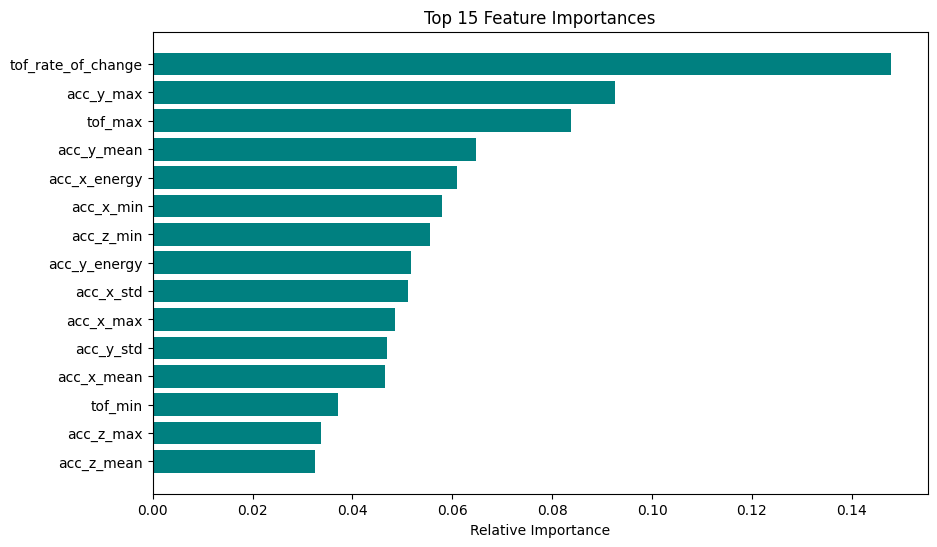

In [13]:
import matplotlib.pyplot as plt
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[-15:]
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], color='teal', align='center')
plt.yticks(range(len(indices)), np.array(X.columns)[indices])
plt.xlabel('Relative Importance')
plt.title('Top 15 Feature Importances')
plt.show()


In [12]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_bfrb, test_size=0.2, random_state=42, stratify=y_bfrb)

rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_val)

print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred, average='macro'))


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89       600
           1       0.92      0.95      0.94      1011

    accuracy                           0.92      1611
   macro avg       0.92      0.91      0.91      1611
weighted avg       0.92      0.92      0.92      1611

Confusion Matrix:
 [[517  83]
 [ 48 963]]
F1 Score: 0.9119343349725944


In [35]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_val)
print("CatBoost F1 Score:", f1_score(y_val, cat_preds, average='macro'))


CatBoost F1 Score: 0.9231946609997691


In [14]:
# Load test data
test_df = pd.read_csv('/kaggle/input/sensor-data/test.csv')
test_demo = pd.read_csv('/kaggle/input/sensor-data/test_demographics.csv')

# Apply same feature extraction
test_features_df = test_df.groupby('sequence_id').apply(extract_features).reset_index()
test_features_df = test_features_df.dropna()
X_test = test_features_df.drop(columns=['sequence_id'])

# Scale test data using previously fitted scaler
X_test_scaled = scaler.transform(X_test)

# Predict
test_preds = rf_clf.predict(X_test_scaled)

# Prepare submission file
submission = pd.DataFrame({
    'sequence_id': test_features_df['sequence_id'],
    'is_bfrb': test_preds
})
submission.to_csv('submission.csv', index=False)


In [15]:
import joblib
joblib.dump(rf_clf, 'bfrb_rf_model.pkl')
joblib.dump(scaler, 'bfrb_scaler.pkl')


['bfrb_scaler.pkl']

In [60]:
# WARNING: This is a dummy fix — adjust with your actual labels
features_df['is_bfrb'] = 0  # or fill with your labels here


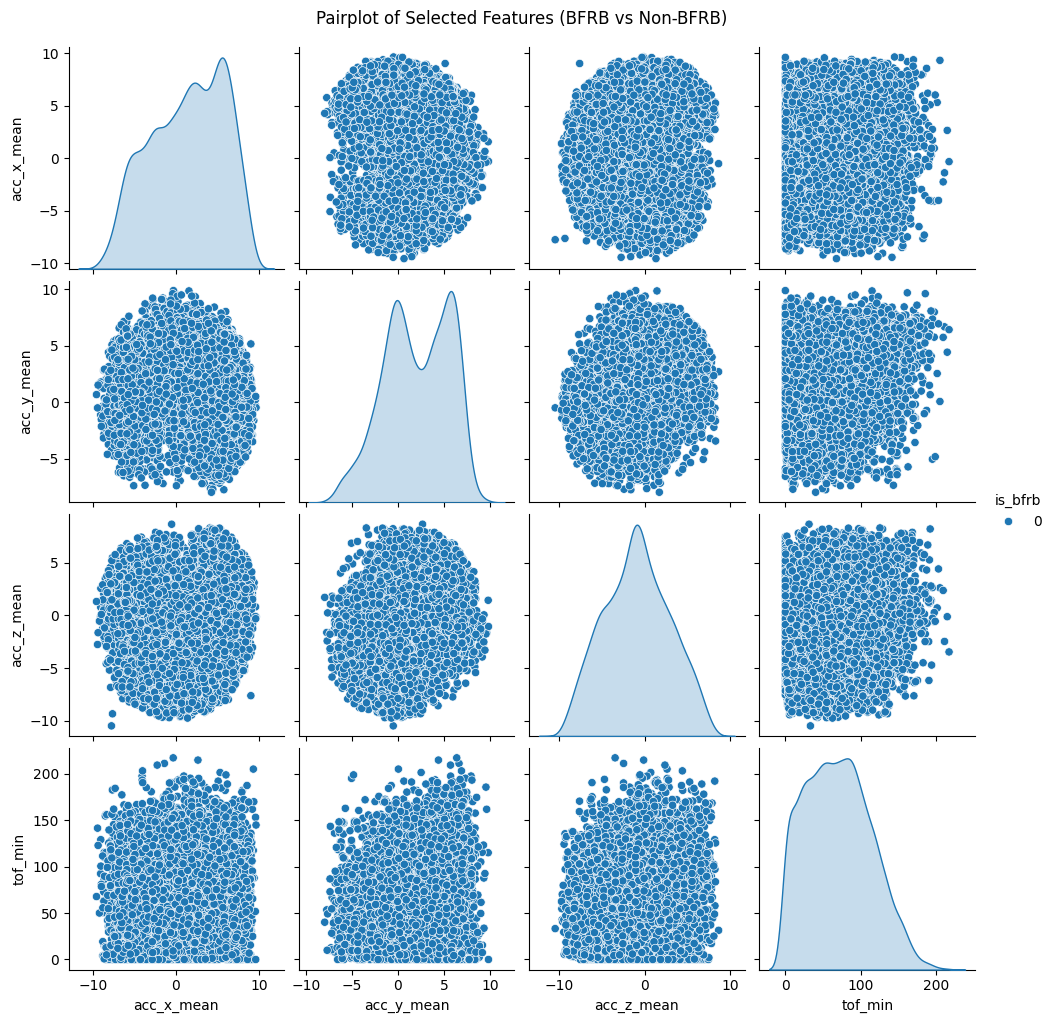

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select columns that exist in your features_df
selected_features = ['acc_x_mean', 'acc_y_mean', 'acc_z_mean', 'tof_min', 'is_bfrb']

# Create pairplot
sns.pairplot(features_df[selected_features], hue='is_bfrb')
plt.suptitle("Pairplot of Selected Features (BFRB vs Non-BFRB)", y=1.02)
plt.show()


In [16]:
print(features_df.columns.tolist())


['sequence_id', 'acc_x_mean', 'acc_x_std', 'acc_x_max', 'acc_x_min', 'acc_x_energy', 'acc_y_mean', 'acc_y_std', 'acc_y_max', 'acc_y_min', 'acc_y_energy', 'acc_z_mean', 'acc_z_std', 'acc_z_max', 'acc_z_min', 'acc_z_energy', 'tof_min', 'tof_max', 'tof_rate_of_change', 'sequence_type']


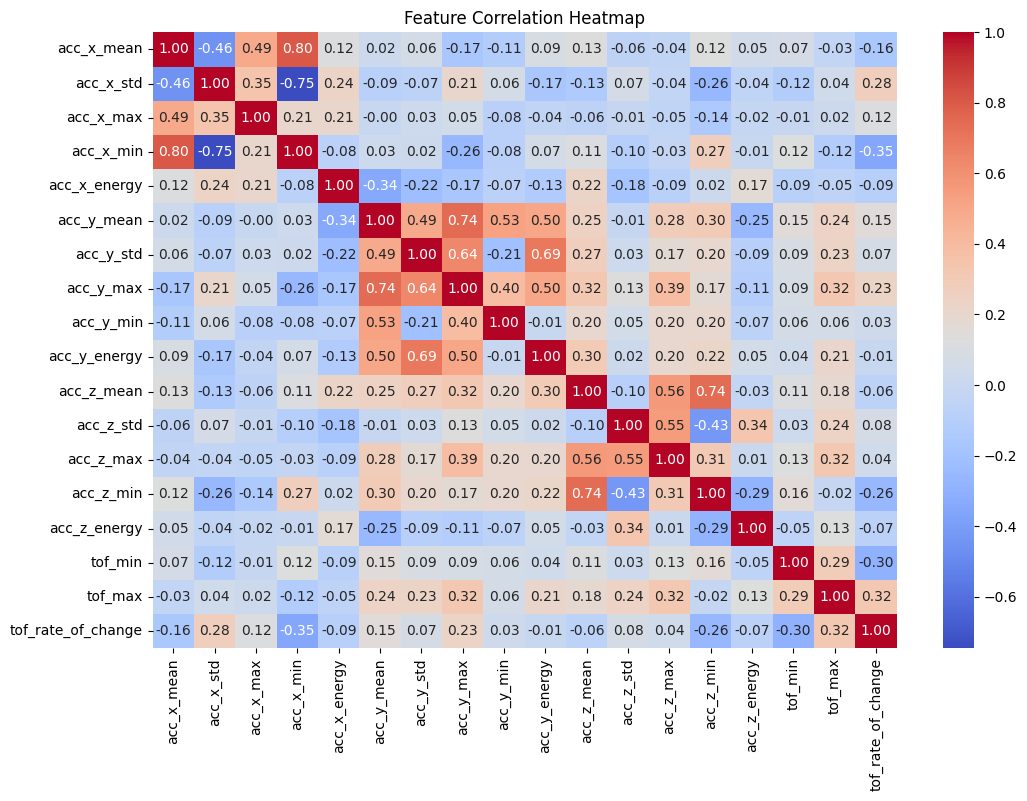

In [20]:
plt.figure(figsize=(12, 8))
sns.heatmap(features_df.drop(columns=['sequence_id', 'sequence_type']).corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


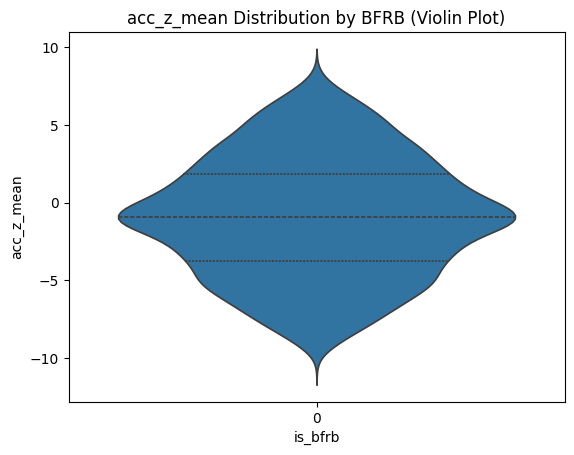

In [62]:
sns.violinplot(data=features_df, x='is_bfrb', y='acc_z_mean', inner="quart")
plt.title("acc_z_mean Distribution by BFRB (Violin Plot)")
plt.show()



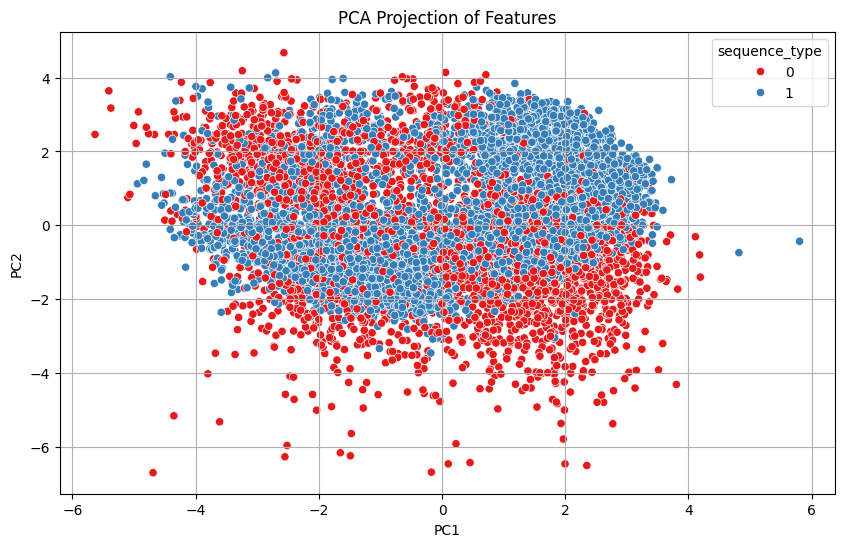

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_bfrb, palette='Set1')
plt.title("PCA Projection of Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


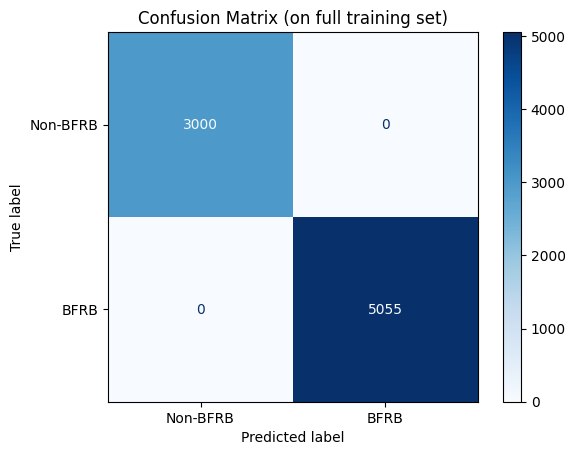

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

rf_clf.fit(X_scaled, y_bfrb)
y_pred = rf_clf.predict(X_scaled)
cm = confusion_matrix(y_bfrb, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-BFRB', 'BFRB'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (on full training set)")
plt.show()


In [26]:
gesture_labels = train_df['gesture'].unique().tolist()
print(gesture_labels)


['Cheek - pinch skin', 'Forehead - pull hairline', 'Write name on leg', 'Feel around in tray and pull out an object', 'Neck - scratch', 'Neck - pinch skin', 'Eyelash - pull hair', 'Eyebrow - pull hair', 'Forehead - scratch', 'Above ear - pull hair', 'Wave hello', 'Write name in air', 'Text on phone', 'Pull air toward your face', 'Pinch knee/leg skin', 'Scratch knee/leg skin', 'Drink from bottle/cup', 'Glasses on/off']


In [27]:
bfrb_gestures = ['hair_pull', 'skin_rub', ..., 'nose_touch']  # 8 gestures


In [28]:
non_bfrb_gestures = list(set(gesture_labels) - set(bfrb_gestures))


In [29]:
def remap_labels(gesture):
    return gesture if gesture in bfrb_gestures else 'non_target'

train_df['gesture_mapped'] = train_df['gesture'].apply(remap_labels)


In [30]:
features = ['acc_x_mean', 'acc_y_mean', 'acc_z_mean',
            'acc_x_std', ..., 'tof_rate_of_change']


In [31]:
def predict_one_sequence(sequence_df):
    # Extract same features as training
    feature_vector = extract_features(sequence_df)  # returns DataFrame of shape (1, n_features)
    # Apply preprocessing (scaler, imputer)
    feature_vector = imputer.transform(feature_vector)
    feature_vector = scaler.transform(feature_vector)
    # Predict class
    prediction = final_model.predict(feature_vector)[0]
    return prediction


In [32]:
# Provided API will call this
def predict(test_sequence: pd.DataFrame, test_subject: pd.DataFrame) -> str:
    return predict_one_sequence(test_sequence)


In [38]:
from xgboost import XGBClassifier

# Define and train XGBoost model for binary classification (is_bfrb)
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [39]:
from sklearn.ensemble import VotingClassifier

# Combine models in an ensemble
ensemble = VotingClassifier(estimators=[
    ('rf', rf_clf),
    ('xgb', xgb_clf),
    ('cat', cat_model)
], voting='soft')

ensemble.fit(X_train, y_train)
ensemble_preds = ensemble.predict(X_val)

# Print F1 score
from sklearn.metrics import f1_score
print("Ensemble F1 Score:", f1_score(y_val, ensemble_preds, average='macro'))


Ensemble F1 Score: 0.9269395962599185


In [40]:
def extract_fft_features(series):
    fft_vals = fft(series.dropna())
    fft_power = np.abs(fft_vals)**2
    return {
        'fft_energy': np.sum(fft_power),
        'fft_peak': np.max(fft_power),
    }


In [42]:
gesture_labels = train_df['gesture'].unique().tolist()


In [43]:
train_df['gesture_mapped'] = train_df['gesture'].apply(remap_labels)


In [45]:
print(features_df.columns)  # Does it include 'gesture'?
print(train_df['gesture'].unique())  # Are there valid gesture labels?


Index(['sequence_id', 'acc_x_mean', 'acc_x_std', 'acc_x_max', 'acc_x_min',
       'acc_x_energy', 'acc_y_mean', 'acc_y_std', 'acc_y_max', 'acc_y_min',
       'acc_y_energy', 'acc_z_mean', 'acc_z_std', 'acc_z_max', 'acc_z_min',
       'acc_z_energy', 'tof_min', 'tof_max', 'tof_rate_of_change',
       'sequence_type'],
      dtype='object')
['Cheek - pinch skin' 'Forehead - pull hairline' 'Write name on leg'
 'Feel around in tray and pull out an object' 'Neck - scratch'
 'Neck - pinch skin' 'Eyelash - pull hair' 'Eyebrow - pull hair'
 'Forehead - scratch' 'Above ear - pull hair' 'Wave hello'
 'Write name in air' 'Text on phone' 'Pull air toward your face'
 'Pinch knee/leg skin' 'Scratch knee/leg skin' 'Drink from bottle/cup'
 'Glasses on/off']


In [46]:
# Extract gesture label per sequence from train_df
gesture_labels = train_df.groupby('sequence_id')['gesture'].first().reset_index()

# Merge with features_df
features_df = features_df.merge(gesture_labels, on='sequence_id', how='left')

# Now define y_gesture
y_gesture = features_df['gesture']

# Drop rows with missing gesture labels if any
valid_idx = y_gesture.notna()
features_df = features_df[valid_idx]
X = features_df.drop(columns=['sequence_id', 'sequence_type', 'gesture'])
y_gesture = y_gesture[valid_idx]

# Re-scale features
X_scaled = scaler.fit_transform(X)


In [48]:
from sklearn.preprocessing import LabelEncoder

# Initialize encoder
le = LabelEncoder()

# Fit and transform training labels to numeric
y_train_encoded = le.fit_transform(y_train)

# Also transform validation labels for evaluation
y_val_encoded = le.transform(y_val)

# Now train with encoded labels
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train, y_train_encoded)

# Predict on validation set
y_pred_encoded = xgb_clf.predict(X_val)

# Convert predictions back to original labels (optional)
y_pred = le.inverse_transform(y_pred_encoded)

# Calculate F1 score using encoded labels
from sklearn.metrics import f1_score
print("Gesture Classification F1 Score:", f1_score(y_val_encoded, y_pred_encoded, average='macro'))


Gesture Classification F1 Score: 0.4458031862339835


Validation Accuracy: 0.4370
                                            precision    recall  f1-score   support

                     Above ear - pull hair       0.42      0.50      0.45       126
                        Cheek - pinch skin       0.28      0.25      0.27       126
                     Drink from bottle/cup       0.70      0.59      0.64        32
                       Eyebrow - pull hair       0.20      0.21      0.20       126
                       Eyelash - pull hair       0.33      0.26      0.29       126
Feel around in tray and pull out an object       0.76      0.78      0.77        32
                  Forehead - pull hairline       0.40      0.38      0.39       126
                        Forehead - scratch       0.48      0.53      0.50       126
                            Glasses on/off       0.46      0.59      0.52        32
                         Neck - pinch skin       0.31      0.31      0.31       127
                            Neck - scratch     

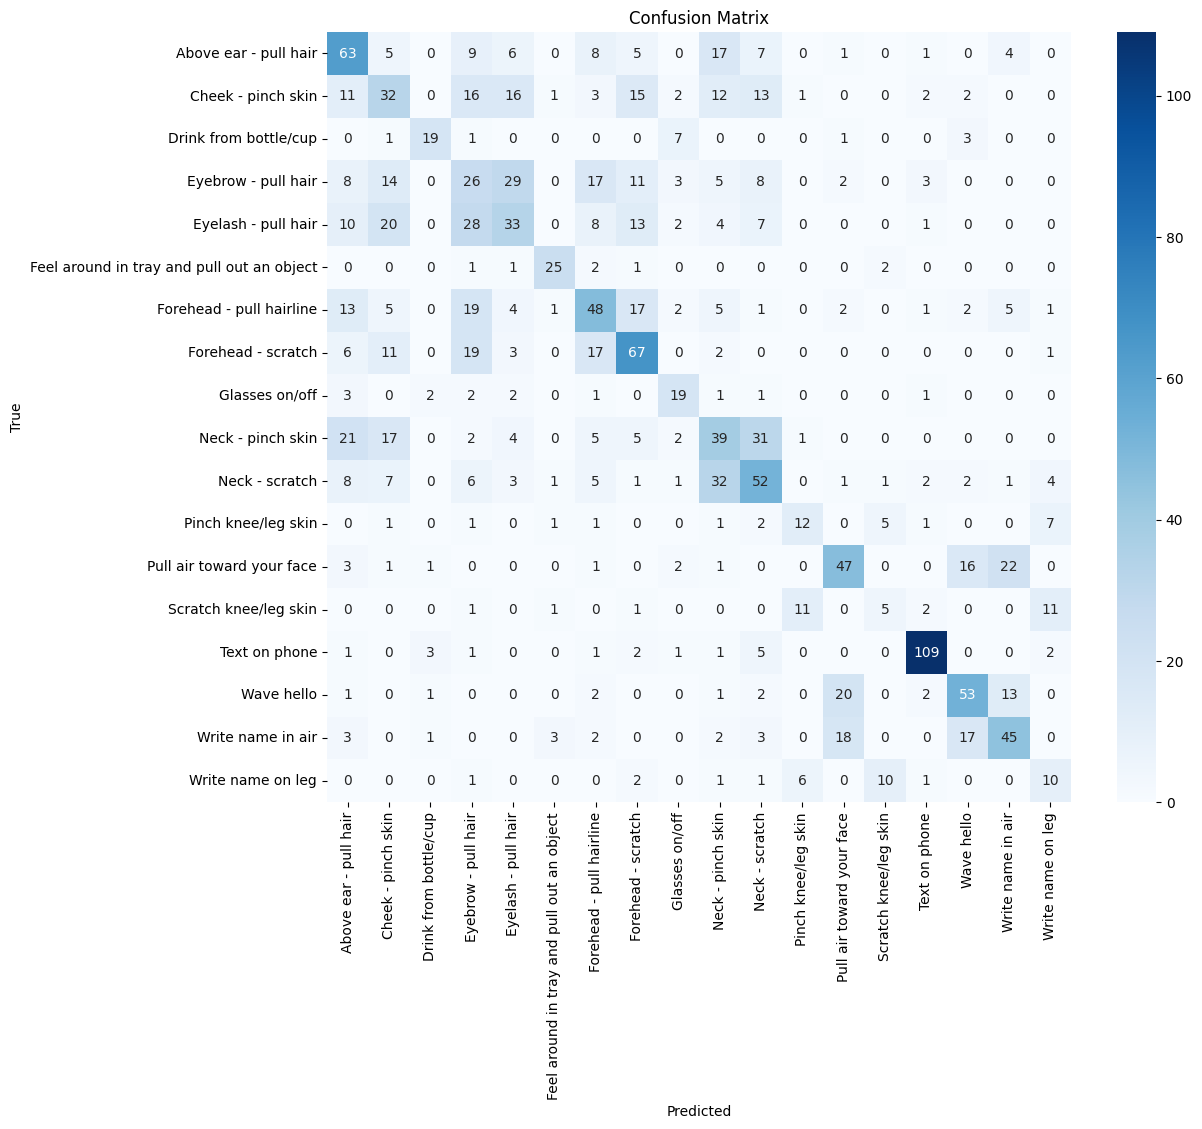

In [49]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Accuracy
acc = accuracy_score(y_val_encoded, y_pred_encoded)
print(f"Validation Accuracy: {acc:.4f}")

# Detailed report
print(classification_report(y_val_encoded, y_pred_encoded, target_names=le.classes_))

# Confusion matrix heatmap
cm = confusion_matrix(y_val_encoded, y_pred_encoded)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [53]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

param_dist = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]
}

random_search = RandomizedSearchCV(
    xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_distributions=param_dist,
    n_iter=5,          # Try 5 random combinations
    cv=3,
    scoring='f1_macro',
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train_encoded)

print("Best params:", random_search.best_params_)
print("Best score:", random_search.best_score_)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}
Best score: 0.46235973017777904


In [51]:
import joblib

joblib.dump(xgb_clf, 'xgb_gesture_model.pkl')


['xgb_gesture_model.pkl']

In [52]:
model = joblib.load('xgb_gesture_model.pkl')
